## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set pandas options to display full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json', 'r', encoding='utf-8') # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

# Close the file
f.close()

In [4]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
df.shape

(78313, 22)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
# print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
# Assign new column names
column_names = [col[1:].replace('source.', '') for col in list(df.columns)]
df.columns = column_names
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [9]:
# Assign nan in place of blanks in the complaints column
df.replace("", np.nan, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [11]:
int(df['complaint_what_happened'].isnull().sum())

57241

In [12]:
# Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [13]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.
def prepare_text(text):
    text = text.lower() # Make the text lowercase
    text = re.sub(r'\[[^\]]*\]', '', text) # Remove text in square brackets
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\b\w*\d\w*\b', '', text) # Remove words containing numbers
    return text

In [15]:
test = "Hi My Name is Lata[nickname starry].,:; and my id is ASDF12345."
prepare_text(test)

'hi my name is lata and my id is '

In [16]:
# Write your function to Lemmatize the texts
def lemmatize_text(text):
    lemmatized_text = []
    for sentence in tqdm(text):
        doc = nlp(sentence)
        lemma = [token.lemma_ for token in doc]
        lemmatized_text.append(" ".join(lemma))
    return lemmatized_text

In [17]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_what_happened']].copy()

In [18]:
# Apply the 'prepare_text' function to clean the 'complaint_what_happened' column
df_clean['complaint_what_happened'] = df_clean['complaint_what_happened'].apply(lambda x: prepare_text(x))

# Apply lemmatization to the 'complaint_what_happened' column
df_clean['complaint_what_happened_lemmatized'] = lemmatize_text(df_clean['complaint_what_happened'].tolist())

100%|██████████| 21072/21072 [13:40<00:00, 25.69it/s]


In [19]:
# Write your function to extract the POS tags 
def pos_tag(text):
    pos_tagged_text = []
    for sentence in tqdm(text):
        doc = nlp(sentence)
        nn_tag = [token.text for token in doc if token.tag_ == 'NN']
        pos_tagged_text.append(" ".join(nn_tag))
    return pos_tagged_text

df_clean["complaint_POS_removed"] = pos_tag(df_clean['complaint_what_happened_lemmatized'].tolist()) 

# this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

100%|██████████| 21072/21072 [13:38<00:00, 25.73it/s]


In [20]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent anniversary date agent information order account anniversary date consent recording agent mislead
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my informat

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_what_happened_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['complaint_what_happened_lemmatized_length'] = df_clean['complaint_what_happened_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()

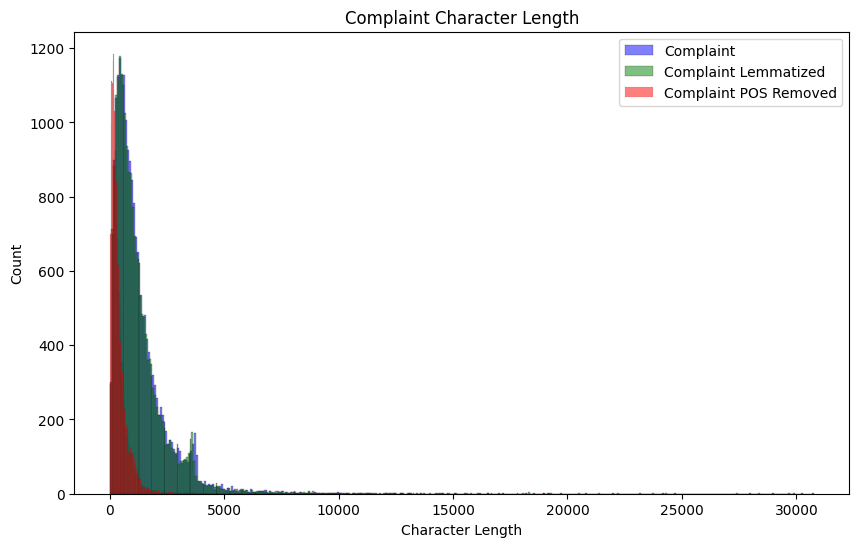

In [22]:
plt.figure(figsize=(10, 6))

sns.histplot(df_clean['complaint_what_happened_length'], label='Complaint', color='blue', alpha=0.5, kde=False)
sns.histplot(df_clean['complaint_what_happened_lemmatized_length'], label='Complaint Lemmatized', color='green', alpha=0.5, kde=False)
sns.histplot(df_clean['complaint_POS_removed_length'], label='Complaint POS Removed', color='red', alpha=0.5, kde=False)

plt.title('Complaint Character Length')
plt.xlabel('Character Length')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [23]:
# !pip install wordcloud

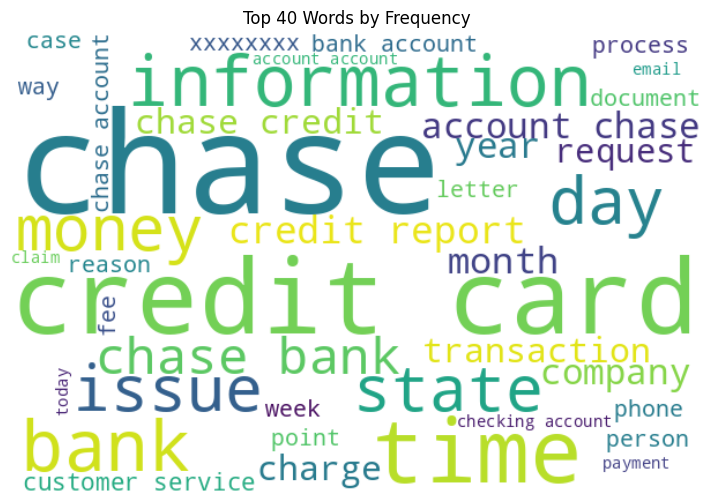

In [24]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
text_corpus = ' '.join(df_clean['complaint_POS_removed'])
stopwords_set = set(nlp.Defaults.stop_words)
wordcloud = WordCloud(stopwords= stopwords_set, width=600, height=400, background_color='white', max_words=40).generate(text_corpus)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 40 Words by Frequency")
plt.show()

In [25]:
# Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams, bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_n_ngrams(text_corpus, n=1, count=30):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    word_counts = vectorizer.fit_transform(text_corpus)
    word_freq = zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).A1)
    top_ngrams = sorted(word_freq, key=lambda x: x[1], reverse=True)[:count]
    return top_ngrams

In [27]:
# Print the top 10 words in the unigram frequency
top10_unigrams = top_n_ngrams(df_clean['Complaint_clean'], n=1, count=10)
for word, freq in top10_unigrams:
    print(f"{word:<10} {freq:<10}")

chase      60049     
account    47223     
credit     33486     
card       30264     
bank       21612     
payment    21151     
time       16007     
charge     14737     
day        12936     
money      11929     


In [28]:
# Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

In [29]:
# Print the top 10 words in the bigram frequency
top10_bigrams = top_n_ngrams(df_clean['Complaint_clean'], n=2, count=10)
for word, freq in top10_bigrams:
    print(f"{word:<20} {freq:<10}")

credit card          12838     
chase bank           3983      
credit report        3947      
account chase        3407      
chase credit         3147      
customer service     3066      
chase account        2804      
bank account         2424      
checking account     2422      
account account      2288      


In [30]:
# Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

In [31]:
# Print the top 10 words in the trigram frequency
top10_trigrams = top_n_ngrams(df_clean['Complaint_clean'], n=3, count=10)
for word, freq in top10_trigrams:
    print(f"{word:<30} {freq:<10}")

chase credit card              2149      
credit card account            1081      
credit card company            988       
credit card chase              798       
chase customer service         611       
inquiry credit report          516       
credit card credit             489       
chase bank account             430       
account credit card            418       
charge credit card             401       


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [32]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [33]:
# All masked texts has been removed
df_clean[['Complaint_clean']].head()

,Complaint_clean
1,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,card agent anniversary date agent information order account anniversary date consent recording agent mislead
10,chase card report application identity consent service credit identity applicant
11,ticket offer ticket reward card information offer minute screen decision chase bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application contrary chase representative chase fact credit account name report credit report chase information credit report application error
14,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date number claim number chase


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [34]:
# Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [35]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [36]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [37]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5 

# Keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [38]:
nmf_model.fit(dtm)
feature_names = tfidf.get_feature_names_out()
len(feature_names)

6766

In [39]:
# Print the Top15 words for each of the topics
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_idx = topic.argsort()[-15:][::-1]  # Get the indices of the top 15 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(top_words)
    print("\n")

Topic 1:
['account', 'check', 'bank', 'money', 'chase', 'fund', 'deposit', 'branch', 'day', 'checking', 'number', 'business', 'transaction', 'transfer', 'customer']


Topic 2:
['credit', 'card', 'report', 'inquiry', 'chase', 'account', 'score', 'company', 'debt', 'limit', 'information', 'application', 'letter', 'year', 'reporting']


Topic 3:
['loan', 'mortgage', 'chase', 'home', 'modification', 'property', 'year', 'letter', 'document', 'rate', 'time', 'foreclosure', 'house', 'sale', 'request']


Topic 4:
['charge', 'card', 'chase', 'fee', 'transaction', 'dispute', 'purchase', 'merchant', 'fraud', 'claim', 'service', 'time', 'statement', 'email', 'refund']


Topic 5:
['payment', 'balance', 'month', 'fee', 'statement', 'day', 'time', 'auto', 'chase', 'date', 'credit', 'account', 'mortgage', 'year', 'error']




In [40]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_distribution = nmf_model.transform(dtm)
best_topic = topic_distribution.argmax(axis=1)
best_topic

array([2, 3, 1, ..., 3, 4, 4])

In [41]:
# Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = best_topic #write your code to assign topics to each rows.

In [42]:
df_clean[['Complaint_clean', 'Topic']].head()

,Complaint_clean,Topic
1,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,2
2,card agent anniversary date agent information order account anniversary date consent recording agent mislead,3
10,chase card report application identity consent service credit identity applicant,1
11,ticket offer ticket reward card information offer minute screen decision chase bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application contrary chase representative chase fact credit account name report credit report chase information credit report application error,1
14,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date number claim number chase,0


In [43]:
# Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_POS_removed,complaint_what_happened_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return the bank associate and the customer service representative assure I that the fund would post but they may take an additional business day that saturday I attempt to go inside of a branch yet again to retrieve my fund that actually do post on friday upon look at my account I realize that the fund have be reverse and no long be present on my current statement I ve be call and I be tell that it may take two business day state tuesday xxxxxxxx would be the date that my fund would be available to withdraw from a bank teller only now chase be inform I that I will be mail a check into the three business day to recover the fund that be owe to I and leave in my account currently unfortunately this have put I in an additional financial bind do two fee from late rent late car payment etc I be not be a short or give write notice that these thing will actually occur so that I have peace of mind in fact chase have handle my situation grossly I even have a bank teller inform I that my account look suspicious after give I a suspicious look myself although I know that chase reserve the right to close my account at any time I do believe that their protocol have be in the past to give notice in the form of a

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [44]:
# Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortage/Loan',
}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [45]:
df_clean[['Complaint_clean', 'Topic']].head()

,Complaint_clean,Topic
1,morning name stop service debt verification statement bank debt mail month debt right information consumer chase account advance help,Others
2,card agent anniversary date agent information order account anniversary date consent recording agent mislead,Theft/Dispute Reporting
10,chase card report application identity consent service credit identity applicant,Credit card or prepaid card
11,ticket offer ticket reward card information offer minute screen decision chase bank chase bank notification screen chase representative application information offer credit offer account statement use ticket account application oblige application request application contrary chase representative chase fact credit account name report credit report chase information credit report application error,Credit card or prepaid card
14,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date number claim number chase,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [46]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']]

In [47]:
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Others
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Theft/Dispute Reporting
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,Credit card or prepaid card
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,Bank Account services


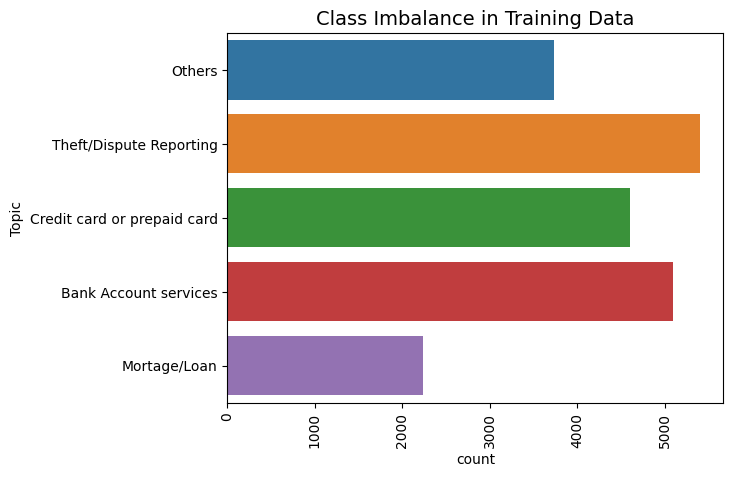

In [48]:
# Check Class Imbalance in the Training Data
sns.countplot(y='Topic', data=training_data, palette='tab10', hue='Topic')
plt.title('Class Imbalance in Training Data', fontsize=14)
plt.xticks(rotation=90)
plt.show()

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vector to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [49]:
# Write your code to get the Vector count
count_vectorizer = CountVectorizer(stop_words='english')
count_dtm = count_vectorizer.fit_transform(training_data['complaint_what_happened'])

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
tfidf_dtm = tfidf_transformer.fit_transform(count_dtm)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [50]:
# Write your code here to build any 3 models and evaluate them using the required metrics

In [51]:
# Importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [52]:
# Train-Test Split
X = tfidf_dtm                # Features
y = training_data['Topic']   # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

## 1. Logistic Regression

In [53]:
%%time
# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=40)

# Define StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],            # Regularization strength
    'penalty': ['l2', None],                   # Regularization type
    'class_weight': [None, 'balanced']         # Class Weights
}

# Initilize GridSearchCV for Hyper-parameter Tuning
grid_search_lr = GridSearchCV(log_reg, param_grid, cv=cv, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Fit the model
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 1.84 s
Wall time: 2min 23s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=40, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=40),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l2', None]},
             scoring='f1_weighted', verbose=1)

In [54]:
# Get the best parameters
print("Best Hyperparameters:", grid_search_lr.best_params_)

# Get the best model
lr_best_model = grid_search_lr.best_estimator_

# Predict on train set
y_pred = lr_best_model.predict(X_train)

# Evaluate performance
print(f"{'Accuracy Score:':<40} {accuracy_score(y_train, y_pred):.4f}")
print(f"{'Precision Score:':<40} {precision_score(y_train, y_pred, average='weighted'):.4f}")
print(f"{'Recall Score:':<40} {recall_score(y_train, y_pred, average='weighted'):.4f}")
print(f"{'F1 Score:':<40} {f1_score(y_train, y_pred, average='weighted'):.4f}")

Best Hyperparameters: {'C': 0.001, 'class_weight': 'balanced', 'penalty': None}
Accuracy Score:                          0.9989
Precision Score:                         0.9989
Recall Score:                            0.9989
F1 Score:                                0.9989


Accuracy Score:                          0.9345
Precision Score:                         0.9349
Recall Score:                            0.9345
F1 Score:                                0.9346
ROC AUC Score:                           0.9950

Classification Report:
                             precision    recall  f1-score   support

      Bank Account services       0.95      0.94      0.95      1033
Credit card or prepaid card       0.94      0.92      0.93       921
               Mortage/Loan       0.95      0.93      0.94       455
                     Others       0.95      0.95      0.95       742
    Theft/Dispute Reporting       0.90      0.93      0.92      1064

                   accuracy                           0.93      4215
                  macro avg       0.94      0.93      0.94      4215
               weighted avg       0.93      0.93      0.93      4215



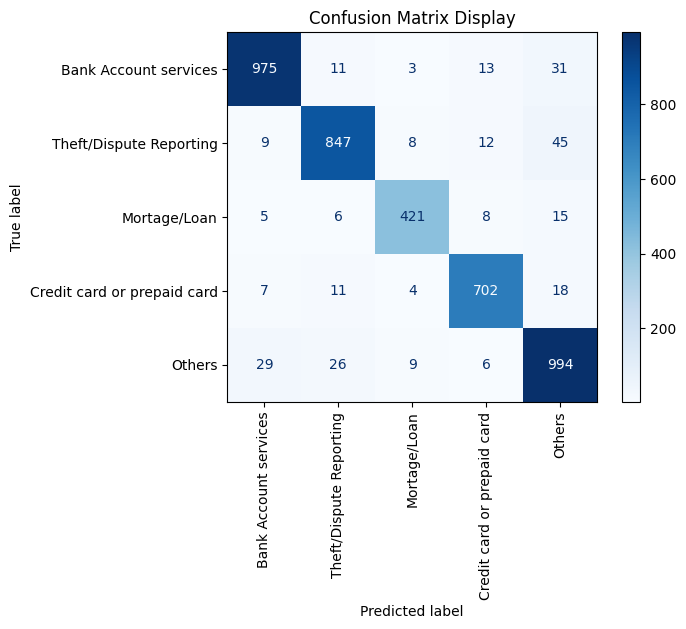

In [55]:
# Predict on test set
y_pred = lr_best_model.predict(X_test)

# Evaluate performance
print(f"{'Accuracy Score:':<40} {(lr_accuracy:=accuracy_score(y_test, y_pred)):.4f}")
print(f"{'Precision Score:':<40} {(lr_precision:=precision_score(y_test, y_pred, average='weighted')):.4f}")
print(f"{'Recall Score:':<40} {(lr_recall:=recall_score(y_test, y_pred, average='weighted')):.4f}")
print(f"{'F1 Score:':<40} {(lr_f1:=f1_score(y_test, y_pred, average='weighted')):.4f}")

# Compute ROC-AUC Score (only for binary or multi-class classification)
y_pred_prob = lr_best_model.predict_proba(X_test)
print(f"{'ROC AUC Score:':<40} {(lr_roc_auc:=roc_auc_score(y_test, y_pred_prob, average='weighted', multi_class='ovr')):.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix Display")
plt.xticks(rotation=90)
plt.show()

## 2. Decision Tree

In [56]:
%%time

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=40)

# Define StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],         # Splitting criterion
    'splitter': ['best'],                     # Splitting Method
    'max_depth': [5, 10, 20, None],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],            # Minimum samples per leaf
    'class_weight': [None, 'balanced']        # Handle class imbalance
}

# Initialize GridSearchCV for Hyper-parameter Tuning
grid_search_dt = GridSearchCV(dt, param_grid, cv=cv, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Fit the model
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
CPU times: total: 14 s
Wall time: 18min 19s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=40, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=40), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best']},
             scoring='f1_weighted', verbose=1)

In [57]:
# Get the best parameters
print("Best Hyperparameters:", grid_search_dt.best_params_)

# Get the best model
dt_best_model = grid_search_dt.best_estimator_

# Predict on train set
y_pred = dt_best_model.predict(X_train)

# Evaluate performance
print(f"{'Accuracy Score:':<40} {accuracy_score(y_train, y_pred):.4f}")
print(f"{'Precision Score:':<40} {precision_score(y_train, y_pred, average='weighted'):.4f}")
print(f"{'Recall Score:':<40} {recall_score(y_train, y_pred, average='weighted'):.4f}")
print(f"{'F1 Score:':<40} {f1_score(y_train, y_pred, average='weighted'):.4f}")

Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy Score:                          0.9092
Precision Score:                         0.9105
Recall Score:                            0.9092
F1 Score:                                0.9093


Accuracy Score:                          0.8002
Precision Score:                         0.8027
Recall Score:                            0.8002
F1 Score:                                0.8005
ROC AUC Score:                           0.9165

Classification Report:
                             precision    recall  f1-score   support

      Bank Account services       0.83      0.78      0.80      1033
Credit card or prepaid card       0.84      0.81      0.83       921
               Mortage/Loan       0.72      0.85      0.78       455
                     Others       0.82      0.83      0.82       742
    Theft/Dispute Reporting       0.77      0.77      0.77      1064

                   accuracy                           0.80      4215
                  macro avg       0.79      0.81      0.80      4215
               weighted avg       0.80      0.80      0.80      4215



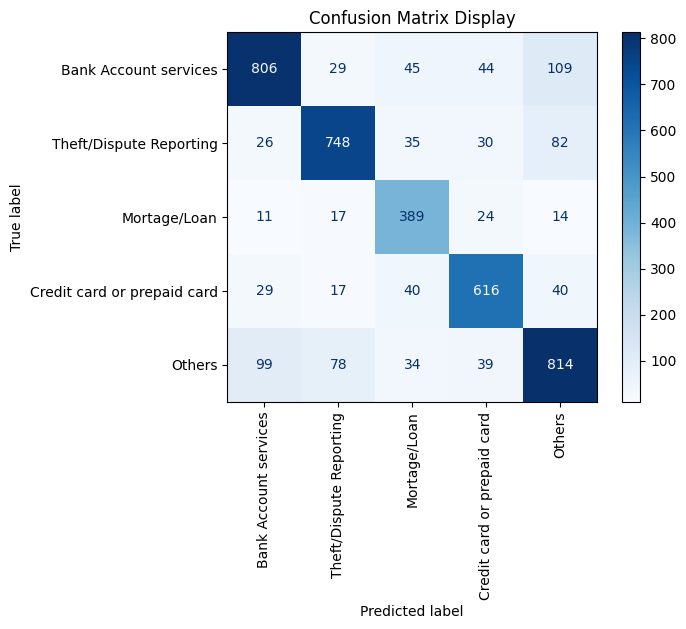

In [58]:
# Predict on test set
y_pred = dt_best_model.predict(X_test)

# Evaluate performance
print(f"{'Accuracy Score:':<40} {(dt_accuracy:=accuracy_score(y_test, y_pred)):.4f}")
print(f"{'Precision Score:':<40} {(dt_precision:=precision_score(y_test, y_pred, average='weighted')):.4f}")
print(f"{'Recall Score:':<40} {(dt_recall:=recall_score(y_test, y_pred, average='weighted')):.4f}")
print(f"{'F1 Score:':<40} {(dt_f1:=f1_score(y_test, y_pred, average='weighted')):.4f}")

# Compute ROC-AUC Score (only for binary or multi-class classification)
y_pred_prob = dt_best_model.predict_proba(X_test)
print(f"{'ROC AUC Score:':<40} {(dt_roc_auc:=roc_auc_score(y_test, y_pred_prob, average='weighted', multi_class='ovr')):.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix Display")
plt.xticks(rotation=90)
plt.show()

## 3. Random Forest

In [59]:
%%time

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=40, oob_score=True)

# Define StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=40)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 500],                     # Number of trees in the forest
    'max_depth': [10, 20, 30, None, 50],                # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20, 50],                 # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 10, 20],                   # Minimum samples per leaf
    'criterion': ['gini', 'entropy'],                        # Splitting criterion
    'class_weight': [None, 'balanced'],                      # Handle class imbalance
    'max_features': ['auto', 'sqrt', 'log2'],          # Number of features to consider for the best split
}

# Initialize GridSearchCV for Hyper-parameter Tuning
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                      n_iter=100, cv=cv, scoring='f1_weighted', 
                                      verbose=1, n_jobs=-1, random_state=40)

# Fit the model
random_search_rf.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
CPU times: total: 1min 42s
Wall time: 21min 48s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=40, shuffle=True),
                   estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=40),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, None, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 10, 20],
                                        'min_samples_split': [2, 5, 10, 20, 50],
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=40, scoring='f1_weighted', verbose=1)

In [60]:
# Get the best parameters
print("Best Hyperparameters:", random_search_rf.best_params_)

# Get the best model
rf_best_model = random_search_rf.best_estimator_

# Predict on train set
y_pred = rf_best_model.predict(X_train)

# Evaluate performance
print(f"{'Accuracy Score:':<40} {accuracy_score(y_train, y_pred):.4f}")
print(f"{'Precision Score:':<40} {precision_score(y_train, y_pred, average='weighted'):.4f}")
print(f"{'Recall Score:':<40} {recall_score(y_train, y_pred, average='weighted'):.4f}")
print(f"{'F1 Score:':<40} {f1_score(y_train, y_pred, average='weighted'):.4f}")

Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced'}
Accuracy Score:                          0.9460
Precision Score:                         0.9462
Recall Score:                            0.9460
F1 Score:                                0.9460


Accuracy Score:                          0.8600
Precision Score:                         0.8596
Recall Score:                            0.8600
F1 Score:                                0.8596
ROC AUC Score:                           0.9781

Classification Report:
                             precision    recall  f1-score   support

      Bank Account services       0.86      0.91      0.88      1033
Credit card or prepaid card       0.87      0.84      0.85       921
               Mortage/Loan       0.81      0.77      0.79       455
                     Others       0.89      0.91      0.90       742
    Theft/Dispute Reporting       0.85      0.84      0.84      1064

                   accuracy                           0.86      4215
                  macro avg       0.86      0.85      0.85      4215
               weighted avg       0.86      0.86      0.86      4215



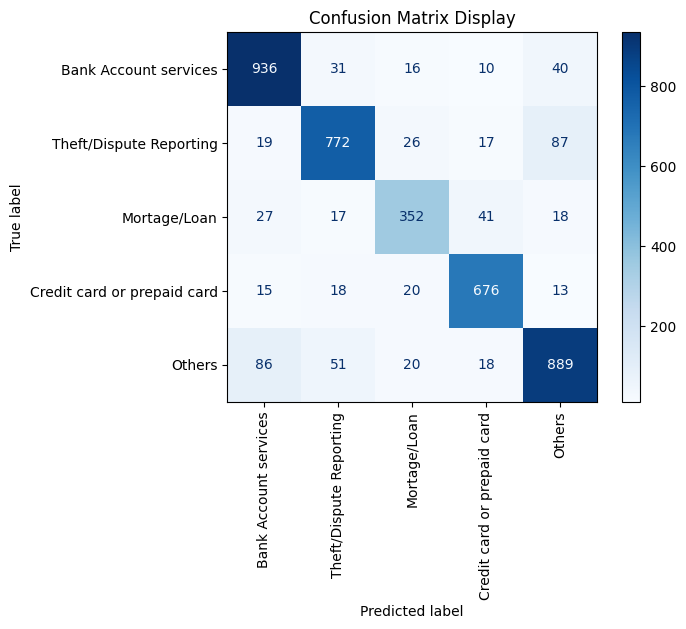

In [61]:
# Predict on test set
y_pred = rf_best_model.predict(X_test)

# Evaluate performance
print(f"{'Accuracy Score:':<40} {(rf_accuracy:=accuracy_score(y_test, y_pred)):.4f}")
print(f"{'Precision Score:':<40} {(rf_precision:=precision_score(y_test, y_pred, average='weighted')):.4f}")
print(f"{'Recall Score:':<40} {(rf_recall:=recall_score(y_test, y_pred, average='weighted')):.4f}")
print(f"{'F1 Score:':<40} {(rf_f1:=f1_score(y_test, y_pred, average='weighted')):.4f}")

# Compute ROC-AUC Score (only for binary or multi-class classification)
y_pred_prob = rf_best_model.predict_proba(X_test)
print(f"{'ROC AUC Score:':<40} {(rf_roc_auc:=roc_auc_score(y_test, y_pred_prob, average='weighted', multi_class='ovr')):.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix Display")
plt.xticks(rotation=90)
plt.show()

## 4. Naive Bayes

In [62]:
%%time

# Initialize Multinomial Naive Bayes Classifier
nb = MultinomialNB()

#Define StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1, 5, 10]  # Smoothing parameter
}

# Initialize GridSearchCV for Hyper-parameter Tuning
grid_search_nb = GridSearchCV(nb, param_grid, cv=cv, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Fit the model
grid_search_nb.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 219 ms
Wall time: 867 ms


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=40, shuffle=True),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1, 5, 10]}, scoring='f1_weighted',
             verbose=1)

In [63]:
# Get the best parameters
print("Best Hyperparameters:", grid_search_nb.best_params_)

# Get the best model
nb_best_model = grid_search_nb.best_estimator_

# Predict on train set
y_pred = nb_best_model.predict(X_train)

# Evaluate performance
print(f"{'Accuracy Score:':<40} {accuracy_score(y_train, y_pred):.4f}")
print(f"{'Precision Score:':<40} {precision_score(y_train, y_pred, average='weighted'):.4f}")
print(f"{'Recall Score:':<40} {recall_score(y_train, y_pred, average='weighted'):.4f}")
print(f"{'F1 Score:':<40} {f1_score(y_train, y_pred, average='weighted'):.4f}")

Best Hyperparameters: {'alpha': 0.1}
Accuracy Score:                          0.8712
Precision Score:                         0.8735
Recall Score:                            0.8712
F1 Score:                                0.8690


Accuracy Score:                          0.7798
Precision Score:                         0.7828
Recall Score:                            0.7798
F1 Score:                                0.7748
ROC AUC Score:                           0.9521

Classification Report:
                             precision    recall  f1-score   support

      Bank Account services       0.79      0.85      0.82      1033
Credit card or prepaid card       0.77      0.77      0.77       921
               Mortage/Loan       0.81      0.45      0.58       455
                     Others       0.84      0.83      0.84       742
    Theft/Dispute Reporting       0.74      0.83      0.78      1064

                   accuracy                           0.78      4215
                  macro avg       0.79      0.75      0.76      4215
               weighted avg       0.78      0.78      0.77      4215



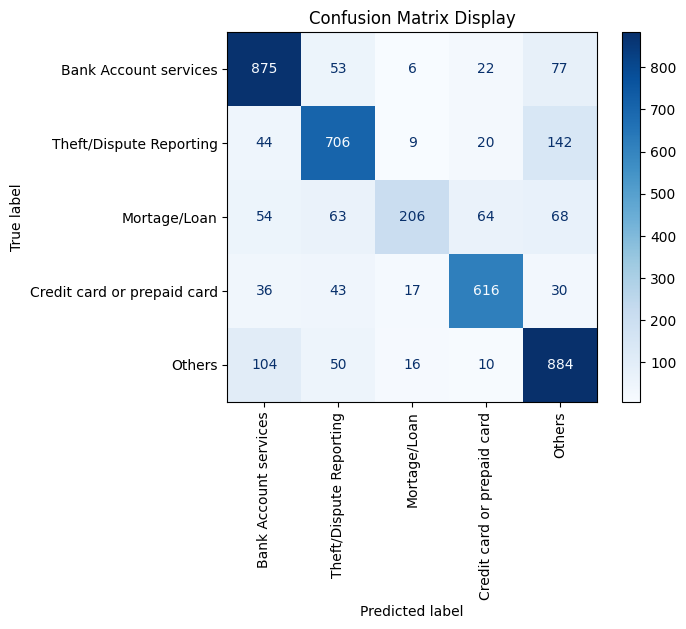

In [64]:
# Predict on test set
y_pred = nb_best_model.predict(X_test)

# Evaluate performance
print(f"{'Accuracy Score:':<40} {(nb_accuracy:=accuracy_score(y_test, y_pred)):.4f}")
print(f"{'Precision Score:':<40} {(nb_precision:=precision_score(y_test, y_pred, average='weighted')):.4f}")
print(f"{'Recall Score:':<40} {(nb_recall:=recall_score(y_test, y_pred, average='weighted')):.4f}")
print(f"{'F1 Score:':<40} {(nb_f1:=f1_score(y_test, y_pred, average='weighted')):.4f}")

# Compute ROC-AUC Score (only for binary or multi-class classification)
y_pred_prob = nb_best_model.predict_proba(X_test)
print(f"{'ROC AUC Score:':<40} {(nb_roc_auc:=roc_auc_score(y_test, y_pred_prob, average='weighted', multi_class='ovr')):.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix Display")
plt.xticks(rotation=90)
plt.show()

# Model Comparison

In [65]:
results = {
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes"],
    "Accuracy": [lr_accuracy, dt_accuracy, rf_accuracy, nb_accuracy],
    "Precision": [lr_precision, dt_precision, rf_precision, nb_precision],
    "Recall": [lr_recall, dt_recall, rf_recall, nb_recall],
    "F1 Score": [lr_f1, dt_f1, rf_f1, nb_f1],
    "ROC AUC": [lr_roc_auc, dt_roc_auc, rf_roc_auc, nb_roc_auc]
}

pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.934520,0.934917,0.934520,0.934602,0.995008
1,Decision Tree,0.800237,0.802655,0.800237,0.800533,0.916504
2,Random Forest,0.860024,0.859620,0.860024,0.859553,0.978111
3,Naive Bayes,0.779834,0.782759,0.779834,0.774804,0.952147


In [66]:
best_model = lr_best_model

# Conclusion

In [67]:
# Define a list of 10 custom texts with more words per sentence to predict
custom_texts = [
    ("I want to report a fraudulent charge on my credit card account. There is an unfamiliar transaction that I did not authorize, and I need to have it removed as soon as possible.", "Credit card or prepaid card"),
    ("I need help with a mortgage payment for my home loan. My payment is due soon, but I am experiencing financial difficulties and would like to explore possible solutions.", "Mortage/Loan"),
    ("I lost my debit card, and I need assistance with getting a replacement. I’m worried about unauthorized access to my bank account and need immediate help in locking the card.", "Bank Account services"),
    ("There is an issue with my credit card billing statement. I have noticed some discrepancies and charges that I don't recognize, and I need customer support to resolve it.", "Credit card or prepaid card"),
    ("Can I dispute a charge I made with my prepaid card? There seems to be an error with the amount charged, and I would like to know how I can initiate the dispute process to correct this.", "Credit card or prepaid card"),
    ("I am facing difficulties with accessing my bank account online. Despite multiple attempts, I cannot log into my account, and I need help resetting my password or troubleshooting the issue.", "Bank Account services"),
    ("I need a loan for home renovation. I'm planning to remodel my kitchen and bathrooms, and I would like to know if I qualify for a home improvement loan and what the interest rates are.", "Mortage/Loan"),
    ("I would like to report unauthorized access to my account. Someone appears to have accessed my account without my permission, and I need assistance in securing my account and preventing further unauthorized activity.", "Bank Account services"),
    ("I have a question regarding my credit card limit and fees. I’m not sure about the current limit on my card and would like more information on any fees associated with exceeding the limit.", "Credit card or prepaid card"),
    ("I want to get a new loan to help finance a new vehicle purchase. Can you guide me through the loan application process and let me know what documents or information are needed for approval?", "Mortage/Loan"),
]

In [68]:
# Predict the custom text with the best model
df = pd.DataFrame(custom_texts, columns=['Complaints', 'Topics'])

count_dtm = count_vectorizer.transform(df['Complaints'])
tfidf_dtm = tfidf_transformer.transform(count_dtm)

df['Predicted_Topics'] = best_model.predict(tfidf_dtm)
df

,Complaints,Topics,Predicted_Topics
0,"I want to report a fraudulent charge on my credit card account. There is an unfamiliar transaction that I did not authorize, and I need to have it removed as soon as possible.",Credit card or prepaid card,Credit card or prepaid card
1,"I need help with a mortgage payment for my home loan. My payment is due soon, but I am experiencing financial difficulties and would like to explore possible solutions.",Mortage/Loan,Mortage/Loan
2,"I lost my debit card, and I need assistance with getting a replacement. I’m worried about unauthorized access to my bank account and need immediate help in locking the card.",Bank Account services,Bank Account services
3,"There is an issue with my credit card billing statement. I have noticed some discrepancies and charges that I don't recognize, and I need customer support to resolve it.",Credit card or prepaid card,Theft/Dispute Reporting
4,"Can I dispute a charge I made with my prepaid card? There seems to be an error with the amount charged, and I would like to know how I can initiate the dispute process to correct this.",Credit card or prepaid card,Theft/Dispute Reporting
5,"I am facing difficulties with accessing my bank account online. Despite multiple attempts, I cannot log into my account, and I need help resetting my password or troubleshooting the issue.",Bank Account services,Bank Account services
6,"I need a loan for home renovation. I'm planning to remodel my kitchen and bathrooms, and I would like to know if I qualify for a home improvement loan and what the interest rates are.",Mortage/Loan,Others
7,"I would like to report unauthorized access to my account. Someone appears to have accessed my account without my permission, and I need assistance in securing my account and preventing further unauthorized activity.",Bank Account services,Bank Account services
8,I have a question regarding my credit card limit and fees. I’m not sure about the current limit on my card and would like more information on any fees associated with exceeding the limit.,Credit card or prepaid card,Credit card or prepaid card
9,I want to get a new loan to help finance a new vehicle purchase. Can you guide me through the loan application process and let me know what documents or information are needed for approval?,Mortage/Loan,Others
